# EndotyPy package usage

In [1]:
import EndotypY as edy #type: ignore
import pickle
import networkx as nx


# manual test case

In [2]:
# 1. Create an empty graph
G_test = nx.Graph()

# 2. Define seeds and the central hub node
seeds = ["S1", "S2", "S3", "S4"]
hub_node = "HUB"
spoke_len = 39 # This ensures the hub is the 40th node added

# 3. Build the spokes and connect them to the hub
for i, seed in enumerate(seeds):
    # The first node in the spoke is the seed itself
    previous_node = seed
    G_test.add_node(seed)
    
    # Create a chain of nodes for the spoke
    for j in range(spoke_len - 1):
        # Node names are unique to each spoke, e.g., "S1_node_1", "S2_node_1"
        new_node = f"{seed}_node_{j}"
        G_test.add_edge(previous_node, new_node)
        previous_node = new_node
        
    # Connect the end of the spoke to the central hub
    G_test.add_edge(previous_node, hub_node)

print(f"Test graph created with {G_test.number_of_nodes()} nodes and {G_test.number_of_edges()} edges.")
print(f"Seeds are: {seeds}")
print(f"Shortest path between S1 and S2 is {len(nx.shortest_path(G_test, 'S1', 'S2')) - 1} hops.")



Test graph created with 157 nodes and 156 edges.
Seeds are: ['S1', 'S2', 'S3', 'S4']
Shortest path between S1 and S2 is 78 hops.


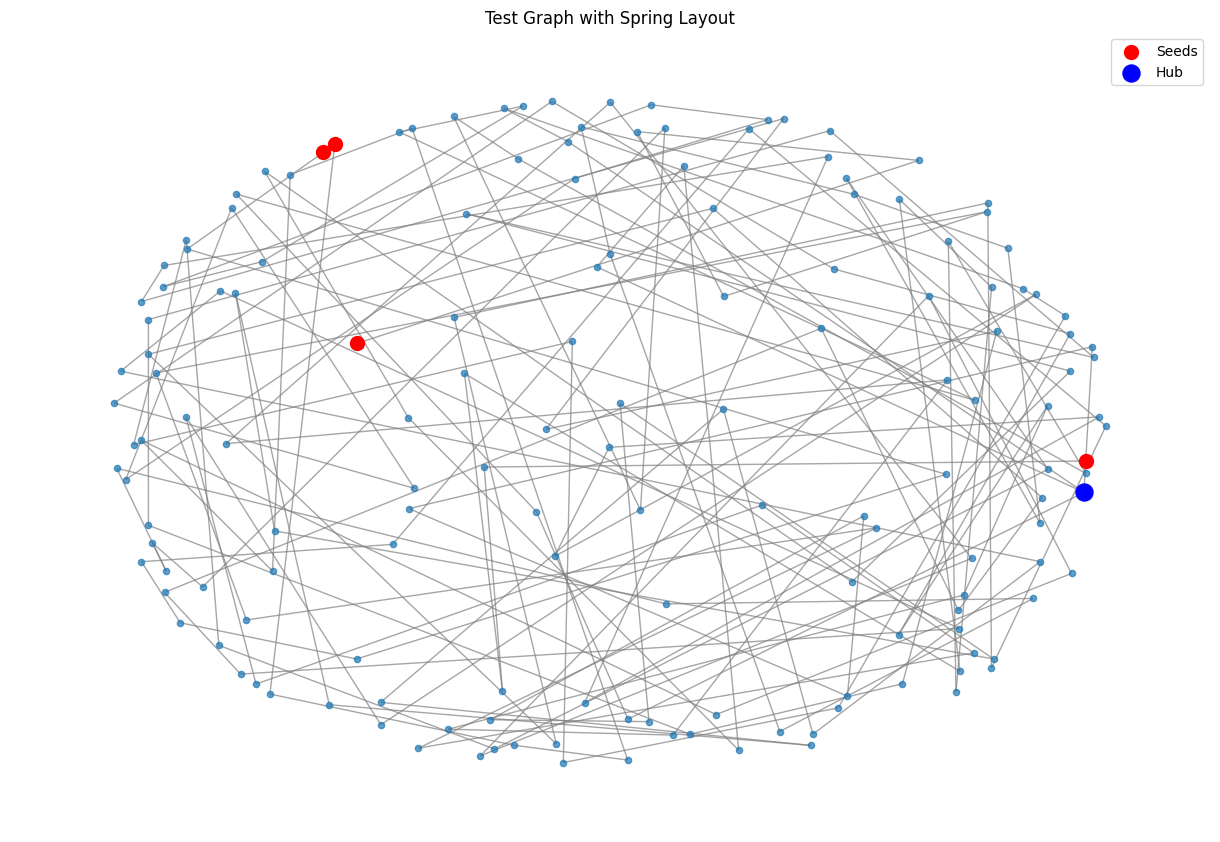

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_test, k=1, iterations=50)
nx.draw(G_test, pos, with_labels=False, node_size=20, edge_color='gray', alpha=0.7)

# Highlight the seeds and hub
nx.draw_networkx_nodes(G_test, pos, nodelist=seeds, node_color='red', node_size=100, label='Seeds')
nx.draw_networkx_nodes(G_test, pos, nodelist=[hub_node], node_color='blue', node_size=150, label='Hub')

plt.legend()
plt.title("Test Graph with Spring Layout")
plt.show()

In [4]:
test_case = edy.Endotyper()
test_case.network = G_test
test_case.seeds = seeds

test_case.prepare_rwr(r=0.8)

Preparing RWR...
Inverting the matrix takes time, please be patient...
RWR matrix prepared successfully


Running RWR for seed genes: 100%|██████████| 4/4 [00:00<00:00, 3987.93it/s]

Testing neighborhood sizes in parallel on 8 cores...



100%|██████████| 6/6 [00:00<00:00, 120410.64it/s]

Optimal neighborhood size found at k=10 with 4 cluster(s).


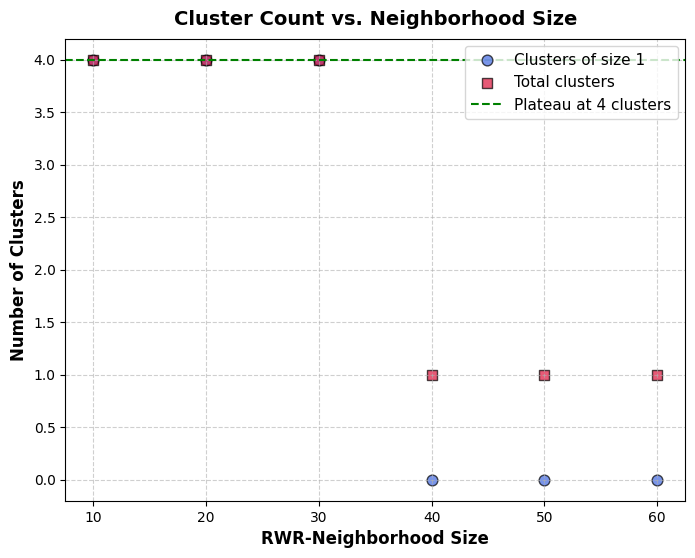

4 Seed clusters identified


{'cluster_seed_1': ['S1'],
 'cluster_seed_2': ['S2'],
 'cluster_seed_3': ['S3'],
 'cluster_seed_4': ['S4']}

In [5]:
test_case.explore_seed_clusters(scaling=True, k=60)

# small use case

In [6]:
path_ppi_mini = '/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/monocyte.tsv'
path_seed_mini = '/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/ibd_risk_genes_mini.txt'

mini = edy.Endotyper()
mini.import_network(path_ppi_mini)
mini.import_seeds(path_seed_mini)

mini

network imported successfully
> Network contains 2866 nodes and 18725 edges

> Loaded 10 seed nodes from file: /Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/ibd_risk_genes_mini.txt
seeds imported successfully


In [7]:
mini.prepare_rwr(r=0.8)

Preparing RWR...
['PTPN22', 'NKX2-3', 'S100A3', 'HNF4A', 'IL2RA', 'EBF1', 'FCN1']
Inverting the matrix takes time, please be patient...
RWR matrix prepared successfully


Running RWR for seed genes: 100%|██████████| 3/3 [00:00<00:00, 198.11it/s]

Testing neighborhood sizes in parallel on 8 cores...



100%|██████████| 6/6 [00:00<00:00, 108942.96it/s]

Optimal neighborhood size found at k=40 with 1 cluster(s).


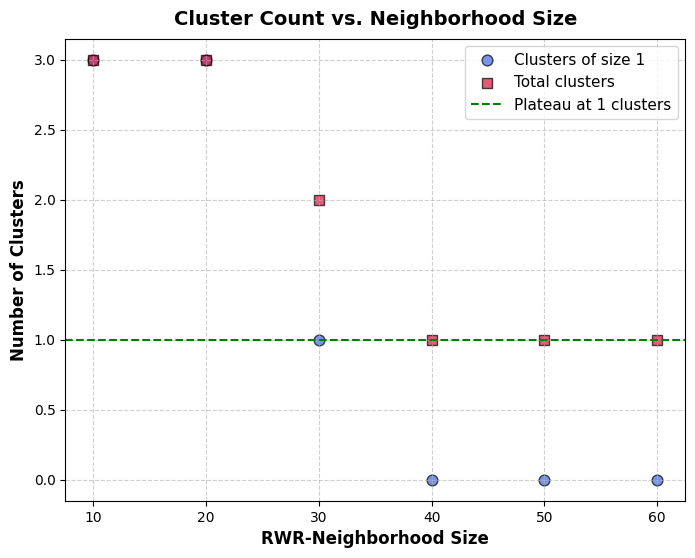

1 Seed clusters identified


{'cluster_seed_1': ['CARD9', 'NOD2', 'LRRK2']}

In [8]:
mini.explore_seed_clusters(scaling=True, k=60)

## larger data

In [9]:
endo = edy.Endotyper()

# read in a graph from a file

#path_ppi = 'ppi.txt'
path_ppi = '/Users/mathilde/Desktop/projects/NetMedRX/test_data/Supplementary_File_1_interactome_edgelist_protein_only.txt'
endo.import_network(path_ppi)

#path_seed = 'ibd_risk_genes_F.txt'
#path_seed = '/Users/mathilde/Desktop/projects/NetMedRX/endotyPy/test_and_dev/ibd_risk_genes_mini.txt'
#read in a seed set from a file
#path_seed = 'example_seeds.txt'
path_seed = '/Users/mathilde/Desktop/projects/NetMedRX/test_data/mono_AIM_AIF_IDs.txt'
endo.import_seeds(path_seed)

endo


network imported successfully
> Network contains 18727 nodes and 476675 edges

> Loaded 186 seed nodes from file: /Users/mathilde/Desktop/projects/NetMedRX/test_data/mono_AIM_AIF_IDs.txt
seeds imported successfully


In [10]:
#prepare RWR
#endo.prepare_rwr(r=0.8)

#from previously saved files
with open('/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/rwr_matrix.pkl', 'rb') as f:
    endo.rwr_matrix = pickle.load(f)
with open('/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/scaling_matrix.pkl', 'rb') as f:
    endo.scaling_matrix = pickle.load(f)
with open('/Users/mathilde/Desktop/projects/NetMedRX/EndotypY_repo/idx_ensembl.pkl', 'rb') as f:
    endo.idx_ensembl = pickle.load(f)

Running RWR for seed genes: 100%|██████████| 186/186 [01:00<00:00,  3.07it/s]

Testing neighborhood sizes in parallel on 8 cores...



100%|██████████| 5/5 [00:00<00:00, 63937.56it/s]

Optimal neighborhood size found at k=20 with 1 cluster(s).


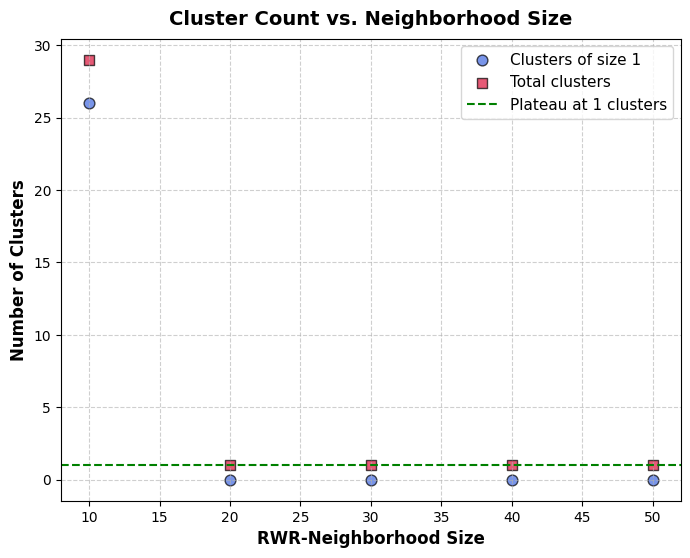

1 Seed clusters identified


{'cluster_seed_1': ['958',
  '3588',
  '4860',
  '55315',
  '26525',
  '731',
  '51095',
  '7056',
  '57217',
  '8546',
  '27040',
  '10747',
  '28755',
  '843',
  '3257',
  '8676',
  '9051',
  '653361',
  '10535',
  '6452',
  '4791',
  '10892',
  '939',
  '5728',
  '5993',
  '5591',
  '3586',
  '10346',
  '5293',
  '4790',
  '717',
  '713',
  '730',
  '50943',
  '6813',
  '1535',
  '8517',
  '10616',
  '201294',
  '64127',
  '721',
  '7535',
  '567',
  '1314',
  '11274',
  '4261',
  '331',
  '729',
  '733',
  '5692',
  '10725',
  '4210',
  '716',
  '714',
  '5698',
  '10095',
  '25939',
  '1675',
  '84061',
  '6774',
  '90268',
  '3587',
  '7132',
  '5994',
  '9652',
  '7128',
  '115650',
  '712',
  '1536',
  '6892',
  '1776',
  '4598',
  '81704',
  '5336',
  '987',
  '6890',
  '355',
  '55139',
  '1130',
  '6789',
  '6578',
  '6023',
  '841',
  '718',
  '248',
  '3559',
  '472',
  '84876',
  '8547',
  '7048',
  '29851',
  '59067',
  '10878',
  '2624',
  '1789',
  '959',
  '11277',
  

In [11]:
#explore the seed clusters
endo.explore_seed_clusters(scaling=True, k=50)

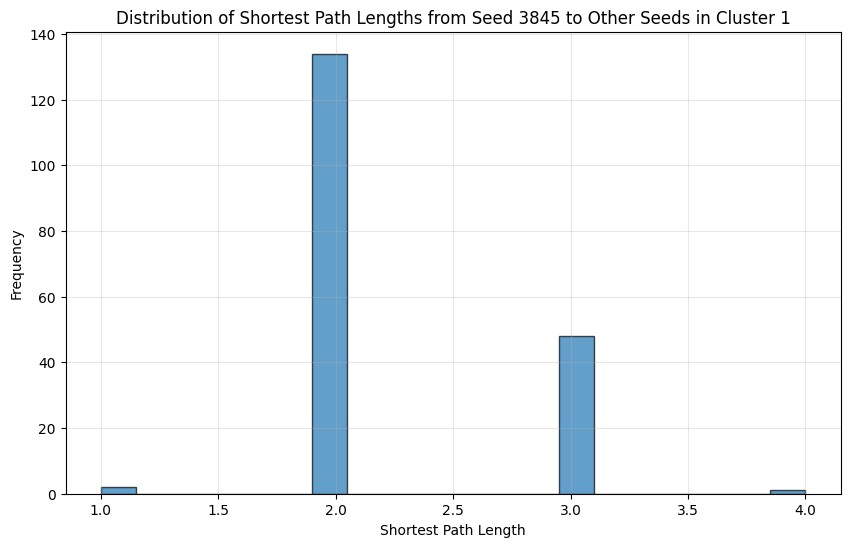

Path lengths from 3845 to other seeds: [2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 4, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3]
Mean distance: 2.26
Min distance: 1
Max distance: 4


In [12]:
endo.network

# Calculate minimum path lengths from seed '3845' to all other seeds in cluster_seed_1
distances = []
source_seed = '3845'

for target_seed in endo.seed_clusters['cluster_seed_1']:
    if target_seed != source_seed:
        try:
            path_length = nx.shortest_path_length(endo.network, source_seed, target_seed)
            distances.append(path_length)
        except nx.NetworkXNoPath:
            # If no path exists, we could append infinity or skip
            distances.append(float('inf'))

# Create histogram of distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequency')
plt.title(f'Distribution of Shortest Path Lengths from Seed {source_seed} to Other Seeds in Cluster 1')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Path lengths from {source_seed} to other seeds: {distances}")
print(f"Mean distance: {sum(d for d in distances if d != float('inf'))/len([d for d in distances if d != float('inf')]):.2f}")
print(f"Min distance: {min(d for d in distances if d != float('inf'))}")
print(f"Max distance: {max(d for d in distances if d != float('inf'))}")

In [13]:
endo.seed_clusters['cluster_seed_1']

['958',
 '3588',
 '4860',
 '55315',
 '26525',
 '731',
 '51095',
 '7056',
 '57217',
 '8546',
 '27040',
 '10747',
 '28755',
 '843',
 '3257',
 '8676',
 '9051',
 '653361',
 '10535',
 '6452',
 '4791',
 '10892',
 '939',
 '5728',
 '5993',
 '5591',
 '3586',
 '10346',
 '5293',
 '4790',
 '717',
 '713',
 '730',
 '50943',
 '6813',
 '1535',
 '8517',
 '10616',
 '201294',
 '64127',
 '721',
 '7535',
 '567',
 '1314',
 '11274',
 '4261',
 '331',
 '729',
 '733',
 '5692',
 '10725',
 '4210',
 '716',
 '714',
 '5698',
 '10095',
 '25939',
 '1675',
 '84061',
 '6774',
 '90268',
 '3587',
 '7132',
 '5994',
 '9652',
 '7128',
 '115650',
 '712',
 '1536',
 '6892',
 '1776',
 '4598',
 '81704',
 '5336',
 '987',
 '6890',
 '355',
 '55139',
 '1130',
 '6789',
 '6578',
 '6023',
 '841',
 '718',
 '248',
 '3559',
 '472',
 '84876',
 '8547',
 '7048',
 '29851',
 '59067',
 '10878',
 '2624',
 '1789',
 '959',
 '11277',
 '50619',
 '6499',
 '9663',
 '50506',
 '51371',
 '1604',
 '998',
 '7456',
 '6777',
 '5897',
 '79092',
 '23495',
 '589